<a href="https://colab.research.google.com/github/yukamara/final_project/blob/main/Sentiment_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd 
import os
import matplotlib.pyplot as plt


# Find the latest version of spark 3.0  from http://www-us.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.2'
spark_version = 'spark-3.1.2'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:13 http://ppa.launchpad.net/graph

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("NaiveBayes").getOrCreate()

In [3]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url ="https://codingbootcamp2021104.s3.us-east-2.amazonaws.com/nlp_summary.csv"
spark.sparkContext.addFile(url)
df = spark.read.csv(SparkFiles.get("nlp_summary.csv"), sep=",", header=True)

# Show DataFrame
df.show()

+---+--------------------+--------+
|_c0|                text|   class|
+---+--------------------+--------+
|  0|Good Quality Dog ...|Positive|
|  1|   Not as Advertised|Negative|
|  2|"""Delight"" says...|Positive|
|  3|      Cough Medicine|Negative|
|  4|         Great taffy|Positive|
|  5|          Nice Taffy|Positive|
|  6|Great!  Just as g...|Positive|
|  7|Wonderful, tasty ...|Positive|
|  8|          Yay Barley|Positive|
|  9|    Healthy Dog Food|Positive|
| 10|The Best Hot Sauc...|Positive|
| 11|"My cats LOVE thi...|Positive|
| 12|My Cats Are Not F...|Negative|
| 13|   fresh and greasy!|Positive|
| 14|Strawberry Twizzl...|Positive|
| 15|Lots of twizzlers...|Positive|
| 16|          poor taste|Negative|
| 17|            Love it!|Positive|
| 18|  GREAT SWEET CANDY!|Positive|
| 19|Home delivered tw...|Positive|
+---+--------------------+--------+
only showing top 20 rows



In [4]:
df.na.drop()
print((df.count(), len(df.columns)))

(925, 3)


In [5]:
from pyspark.sql.functions import length
# Create a length column to be used as a future feature 
data_df = df.withColumn('length', length(df['text']))
data_df.show()

+---+--------------------+--------+------+
|_c0|                text|   class|length|
+---+--------------------+--------+------+
|  0|Good Quality Dog ...|Positive|    21|
|  1|   Not as Advertised|Negative|    17|
|  2|"""Delight"" says...|Positive|    25|
|  3|      Cough Medicine|Negative|    14|
|  4|         Great taffy|Positive|    11|
|  5|          Nice Taffy|Positive|    10|
|  6|Great!  Just as g...|Positive|    45|
|  7|Wonderful, tasty ...|Positive|    22|
|  8|          Yay Barley|Positive|    10|
|  9|    Healthy Dog Food|Positive|    16|
| 10|The Best Hot Sauc...|Positive|    31|
| 11|"My cats LOVE thi...|Positive|    64|
| 12|My Cats Are Not F...|Negative|    36|
| 13|   fresh and greasy!|Positive|    17|
| 14|Strawberry Twizzl...|Positive|    28|
| 15|Lots of twizzlers...|Positive|    40|
| 16|          poor taste|Negative|    10|
| 17|            Love it!|Positive|     8|
| 18|  GREAT SWEET CANDY!|Positive|    18|
| 19|Home delivered tw...|Positive|    23|
+---+------

In [6]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer
# Create all the features to the data set
pos_neg_to_num = StringIndexer(inputCol='class',outputCol='label')
tokenizer = Tokenizer(inputCol="text", outputCol="token_text")
stopremove = StopWordsRemover(inputCol='token_text',outputCol='stop_tokens')
hashingTF = HashingTF(inputCol="stop_tokens", outputCol='hash_token')
idf = IDF(inputCol='hash_token', outputCol='idf_token')

In [7]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vector

# Create feature vectors
clean_up = VectorAssembler(inputCols=['idf_token', 'length'], outputCol='features')

In [8]:
# Create a and run a data processing Pipeline
from pyspark.ml import Pipeline
data_prep_pipeline = Pipeline(stages=[pos_neg_to_num, tokenizer, stopremove, hashingTF, idf, clean_up])

In [9]:
# Fit and transform the pipeline
cleaner = data_prep_pipeline.fit(data_df)
cleaned = cleaner.transform(data_df)

In [10]:

 # Show label and resulting features
cleaned.select(['label', 'features']).show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(262145,[43890,54...|
|  1.0|(262145,[187033,2...|
|  0.0|(262145,[10804,11...|
|  1.0|(262145,[194543,2...|
|  0.0|(262145,[107062,2...|
|  0.0|(262145,[22346,10...|
|  0.0|(262145,[19352,11...|
|  0.0|(262145,[107062,1...|
|  0.0|(262145,[14914,47...|
|  0.0|(262145,[54556,12...|
|  0.0|(262145,[47197,60...|
|  0.0|(262145,[31739,48...|
|  1.0|(262145,[89833,11...|
|  0.0|(262145,[210587,2...|
|  0.0|(262145,[33793,38...|
|  0.0|(262145,[53803,72...|
|  1.0|(262145,[85735,22...|
|  0.0|(262145,[90225,18...|
|  0.0|(262145,[48167,15...|
|  0.0|(262145,[17893,11...|
+-----+--------------------+
only showing top 20 rows



In [11]:
from pyspark.ml.classification import NaiveBayes
# Break data down into a training set and a testing set
training, testing = cleaned.randomSplit([0.7, 0.3])

# Create a Naive Bayes model and fit training data
nb = NaiveBayes()
predictor = nb.fit(training)

In [12]:
 # Tranform the model with the testing data
test_results = predictor.transform(testing)
test_results.show(10)


+---+--------------------+--------+------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|_c0|                text|   class|length|label|          token_text|         stop_tokens|          hash_token|           idf_token|            features|       rawPrediction|         probability|prediction|
+---+--------------------+--------+------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|100|Taste wise it is ...|Positive|    30|  0.0|[taste, wise, it,...|[taste, wise, 6, ...|(262144,[93086,12...|(262144,[93086,12...|(262145,[93086,12...|[-406.45012199212...|[1.0,5.7337242376...|       0.0|
|101|       Great Support|Positive|    13|  0.0|    [great, support]|    [great, support]|(262144,[177817,2...|(262144,[177817,2...|(262145,[177817,2...|[-133.60457804497..

In [13]:
from pyspark.sql.functions import countDistinct
df2=test_results.select(countDistinct("prediction"))

df2.show()

+--------------------------+
|count(DISTINCT prediction)|
+--------------------------+
|                         2|
+--------------------------+



In [14]:
 # Use the Class Evaluator for a cleaner description
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

acc_eval = MulticlassClassificationEvaluator()
acc = acc_eval.evaluate(test_results)
print("Accuracy of model at predicting reviews was: %f" % acc)

Accuracy of model at predicting reviews was: 0.775230


In [15]:
test_results_pd = test_results.toPandas()

In [16]:
test_results_pd['prediction'].value_counts()

0.0    293
1.0      1
Name: prediction, dtype: int64

In [17]:
test_results_pd['label'].value_counts()

0.0    247
1.0     47
Name: label, dtype: int64

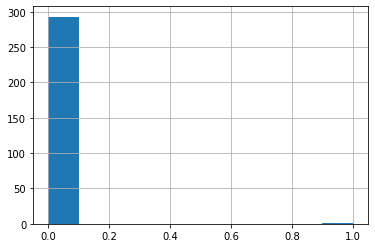

In [18]:
#Place Holder for graph 1 
fig1 = test_results_pd['prediction'].hist()

In [19]:
# Sample Image until graph1 is complete
fig1.savefig('fig1.pdf')

AttributeError: ignored

In [ ]:
#Place Holder for graph 1 
fig2 = test_results_pd['label'].hist()

In [ ]:
# Sample Image until graph2 is complete
fig2.savefig('fig2.pdf')